In [4]:
import numpy as np
import PIL.Image as Image
from matplotlib import pyplot as plt

# Part 1
Physical domain filters:
1. 4-neighborhood Laplacian convolution kernel
    ```plaintext
    [[ 0, 1, 0],
     [ 1,-4, 1],
     [ 0, 1, 0]]
    ```
2. 8-neighborhood Laplacian convolution
    ```plaintext
    [[ 1, 1, 1],
     [ 1,-8, 1],
     [ 1, 1, 1]]
    ```
Fourier domain filters:
1. Inverse Gaussian multiplication mask
    ```plaintext
    f(x,y) = 1/(sigma * sqrt(2*pi)) * [ 1 - exp( -1/2 * (x^2/sigma_x^2 + y^2/sigma_y^2) ) ]
    ```
2. Ideal high-pass filter (square multiplication mask)
    ```plaintext
    f(x,y) = 0   , x < x_cutoff and y < y_cutoff
             1   , else
    ```

# Part 2
Filtering in the spatial domain is computationally faster, because you don't need to compute
the FFT of the image.  You cannot get ideal filters when filtering in the spatial domain,
though.

Filtering in the frequency domain allows you to use ideal filters, but you it is harder to
compute.  You will also introduce aliasing artifacts because of the FFT and IFFT needed
to filter this way.  You also need to decide how much you want to zero-pad the image when
performing the FFT.

# Part 3
The pre-processing phase should include zero-padding, ideally so the padded-image has 
dimensions that are a power of 2.

The post-processing phase must force the complex values of the IFFT to be real valued,
8-bit integers.  The final image must also be resized to the original image dimensions.


In [5]:

def preprocess(fxy):
    ## Preprocess f(x,y)

    ## Determine how much to zero-pad the image
    #  We are determining how many zeros to pad each edge with to make the
    #  image dimensions a power of 2.
    shape = fxy.shape[:2]
    pad_dims = []
    for dim in shape:
        new_dim = 2**np.ceil(np.log2(dim))
        pad_val = int((new_dim - dim)//2)
        pad_dims.append( (pad_val, pad_val) )

    ## Zero-pad the image
    _fxy = np.pad(fxy, pad_dims, mode='constant', constant_values=0)

    return _fxy


def postprocess(gxy, fxy):
    ## Posptrocessing g(x,y)

    ## Isolate only the real component of the image
    g = np.real(gxy)

    ## Remove the zero-padded edges of the image
    target_shape = fxy.shape
    dim_dif = [g.shape[i]-target_shape[i] for i in range(g.ndim)]
    g = g[dim_dif[0]//2:-dim_dif[0]//2 , dim_dif[1]//2:-dim_dif[1]//2]

    return g

/tmp/ipykernel_140231/4057358487.py:24: RuntimeWarning: divide by zero encountered in log
  ax[1,0].imshow(np.log(np.abs(G)), cmap="gray")


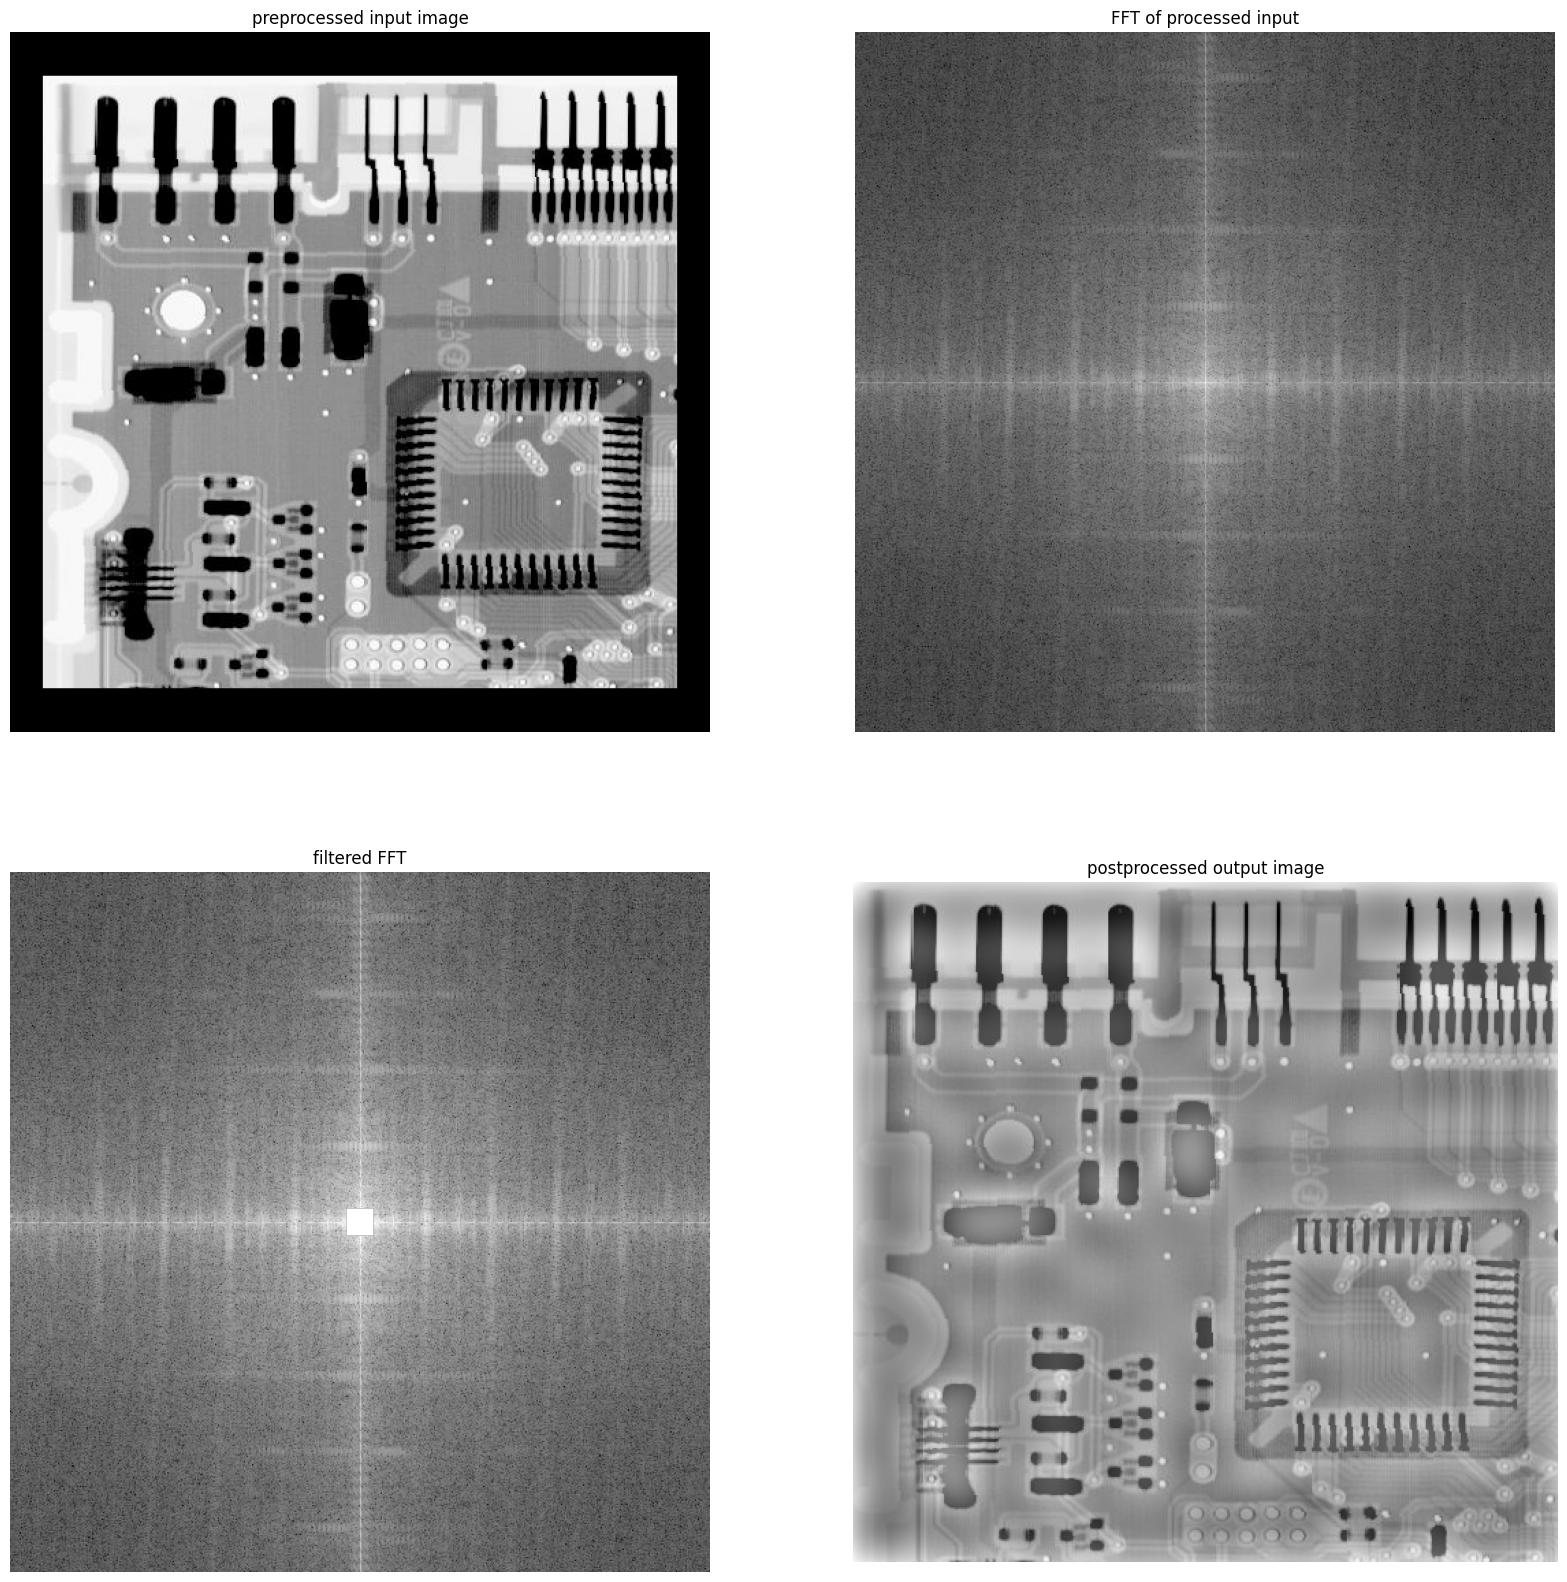

In [6]:
f = np.array(Image.open("Data/Fig0507(a)(ckt-board-orig).tif"))

# Preprocess and take the FFT of the image
_f = preprocess(f)
F = np.fft.fftshift( np.fft.fft2(_f) )


# Filter the image
H = np.ones_like(F)
cx, cy = (F.shape[0]//2, F.shape[1]//2)
H[cx-10:cx+10, cy-10:cy+10] = 0
G = F * H


# IFFT the filtered image
_g = np.fft.ifft2( np.fft.fftshift(G) )
g = postprocess(_g, f)


## Plot the process
fig,ax = plt.subplots(2,2, figsize=(20,20))
ax[0,0].imshow(_f, cmap="gray")
ax[0,1].imshow(np.log(np.abs(F)), cmap="gray")
ax[1,0].imshow(np.log(np.abs(G)), cmap="gray")
ax[1,1].imshow(g, cmap="gray")

ax[0,0].set_title("preprocessed input image")
ax[0,1].set_title("FFT of processed input")
ax[1,0].set_title("filtered FFT")
ax[1,1].set_title("postprocessed output image")

for a in ax.ravel(): a.set_axis_off()
plt.show()